# Visualize Top Geneset Feature Distribution

**Gregory 2019**

Here, I visualize the dimension of the top scoring feature across various geneset collections.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

In [2]:
algorithms <- c("PCA", "ICA", "NMF", "DAE", "VAE")

In [3]:
base_dir <- file.path("results", "top_features")

all_top_list <- list()
list_idx <- 1
for (top_file in list.files(base_dir)) {
    if (grepl("top_biobombe_scores", top_file)) {
        dataset <- strsplit(top_file, '_')[[1]][1]
        collection <- strsplit(top_file, '_')[[1]][2]
        
        top_df <- readr::read_tsv(file.path(base_dir, top_file),
                                col_types = readr::cols(
                                    .default = readr::col_character(),
                                    value = readr::col_double(),
                                    z_score = readr::col_double(),
                                    feature = readr::col_integer(),
                                    z = readr::col_integer(),
                                    abs_z_score = readr::col_double(),
                                    relative_geneset_rank = readr::col_integer(),
                                    absolute_rank = readr::col_integer())) %>%
        dplyr::mutate(collection = collection,
                      dataset = dataset)
        
        all_top_list[[list_idx]] <- top_df
        list_idx <- list_idx + 1
    }
}

In [4]:
all_top_df <- dplyr::bind_rows(all_top_list)

In [5]:
all_top_df$z <- factor(all_top_df$z,
                       levels = sort(as.numeric(paste(unique(all_top_df$z)))))

In [6]:
all_top_df <- all_top_df %>%
    dplyr::group_by(z, collection, dataset, algorithm) %>% 
    dplyr::mutate(num_instance = dplyr::n()) %>%
    dplyr::mutate(normalized_z = num_instance / as.numeric(paste(z))) %>%
    dplyr::ungroup() %>%
    dplyr::mutate(algorithm = toupper(algorithm))

all_top_df$algorithm <- factor(all_top_df$algorithm, levels = algorithms)

In [7]:
# Split TCGA and GTEx data
tcga_top_df <- all_top_df %>%
  dplyr::filter(dataset == "TCGA")

gtex_top_df <- all_top_df %>%
  dplyr::filter(dataset == "GTEX")

## Visualize Results

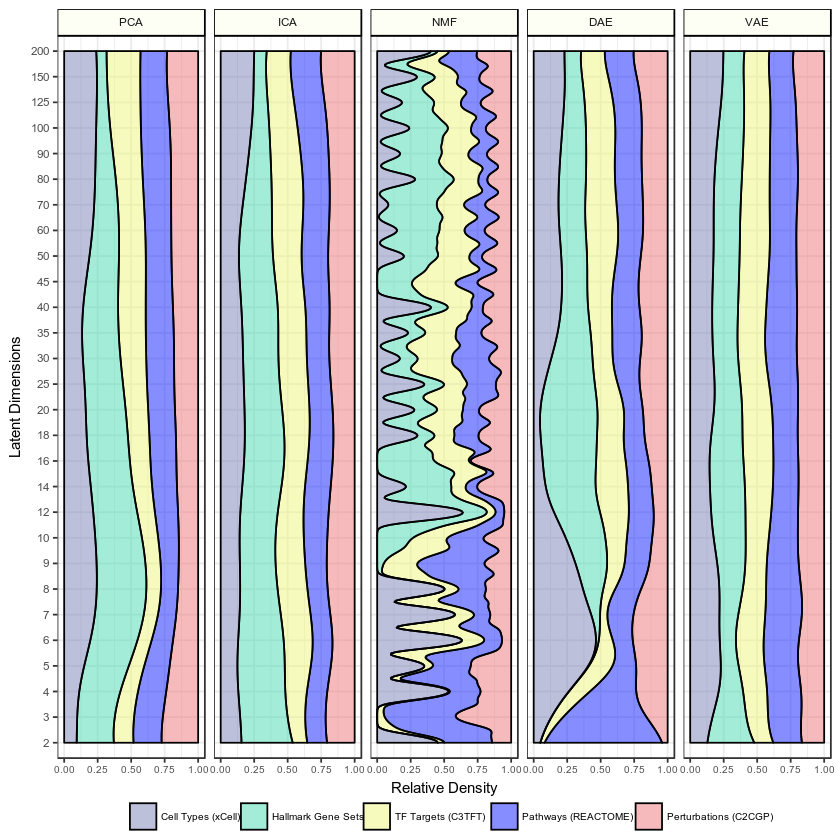

In [8]:
tcga_gg <- ggplot(data = tcga_top_df,
       aes(x = z, fill = collection, group = collection)) +
  geom_density(alpha = 0.5, position = "fill") +
  coord_flip() +
  scale_fill_manual(name = "",
                    values = c("#EF767A",
                               "#0F1FFF",
                               "#EDF67D",
                               "#49DCB1",
                               "#7D82B8"),
                    labels = c("GpC2CPG" = "Perturbations (C2CGP)", 
                               "GpC2CPREACTOME" = "Pathways (REACTOME)",
                               "GpC3TFT" = "TF Targets (C3TFT)",
                               "GpH" = "Hallmark Gene Sets",
                               "GpXCELL" = "Cell Types (xCell)")) +
  facet_wrap( ~ algorithm, ncol = 5) +
  xlab("Latent Dimensions") +
  ylab("Relative Density") +
  theme_bw() +
  theme(strip.background = element_rect(colour = "black",
                                        fill = "#fdfff4"),
        strip.text = element_text(size = 7),
        axis.title = element_text(size = 9),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 7),
        legend.position = 'bottom',
        legend.text = element_text(size = 6),
        legend.margin = margin(0, 0, 0, 0),
        legend.box.margin = margin(-8, 0, 0, 0)) +
    guides(fill = guide_legend(reverse = T))

tcga_gg

In [9]:
theme_gtex <- theme(axis.title = element_text(size = 9),
                    axis.text.x = element_text(size = 8),
                    axis.text.y = element_text(size = 7),
                    legend.position = 'bottom',
                    legend.title = element_text(size = 8),
                    legend.text = element_text(size = 6),
                    legend.margin = margin(0, 0, 0, 0),
                    legend.box.margin = margin(-8, 0, 0, 0))

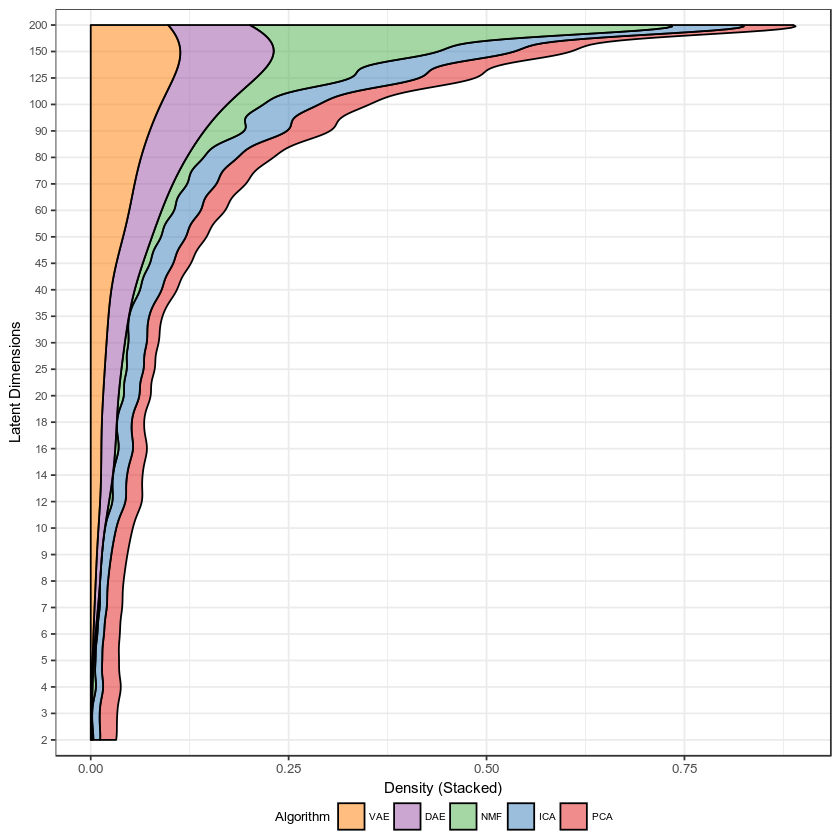

In [10]:
gtex_stack_gg <- ggplot(data = gtex_top_df,
                        aes(x = z, fill = algorithm, group = algorithm)) +
    geom_density(alpha = 0.5, position = "stack") +
    coord_flip() +
    xlab("Latent Dimensions") +
    ylab("Density (Stacked)") +
    scale_fill_manual(name = "Algorithm",
                     values = c("#e41a1c",
                                "#377eb8",
                                "#4daf4a",
                                "#984ea3",
                                "#ff7f00")) +
    theme_bw() +
    theme_gtex +
    guides(fill = guide_legend(reverse = T))

gtex_stack_gg

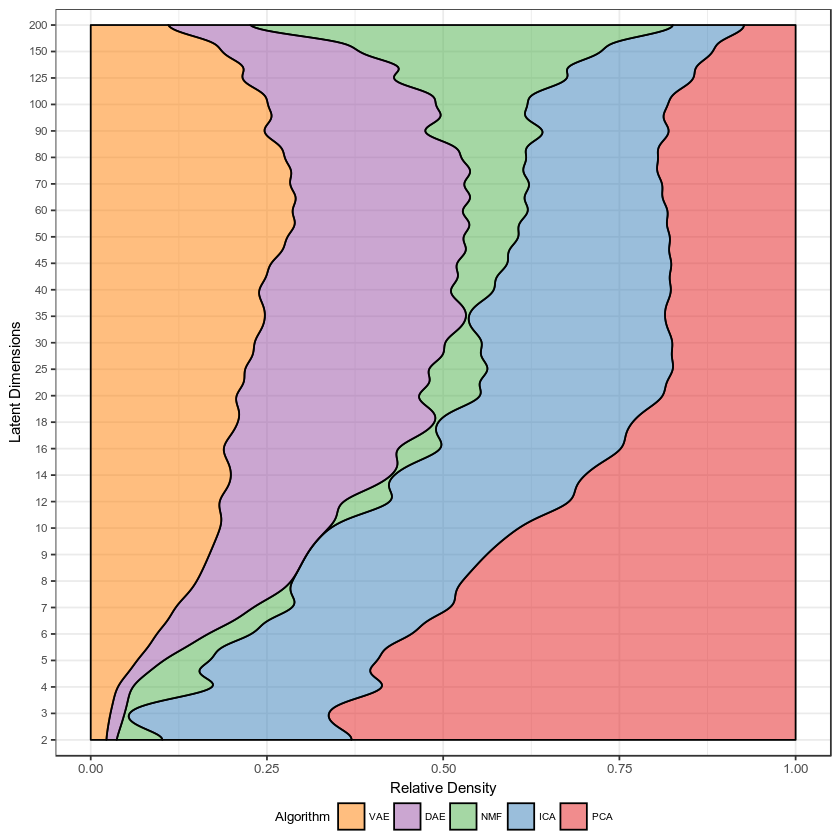

In [11]:
gtex_fill_gg <- ggplot(data = gtex_top_df,
                       aes(x = z, fill = algorithm, group = algorithm)) +
    geom_density(alpha = 0.5, position = "fill") +
    coord_flip() +
    xlab("Latent Dimensions") +
    ylab("Relative Density") +
    scale_fill_manual(name = "Algorithm",
                     values = c("#e41a1c",
                                "#377eb8",
                                "#4daf4a",
                                "#984ea3",
                                "#ff7f00")) +
    theme_bw() +
    theme_gtex +
    guides(fill = guide_legend(reverse = T))


gtex_fill_gg

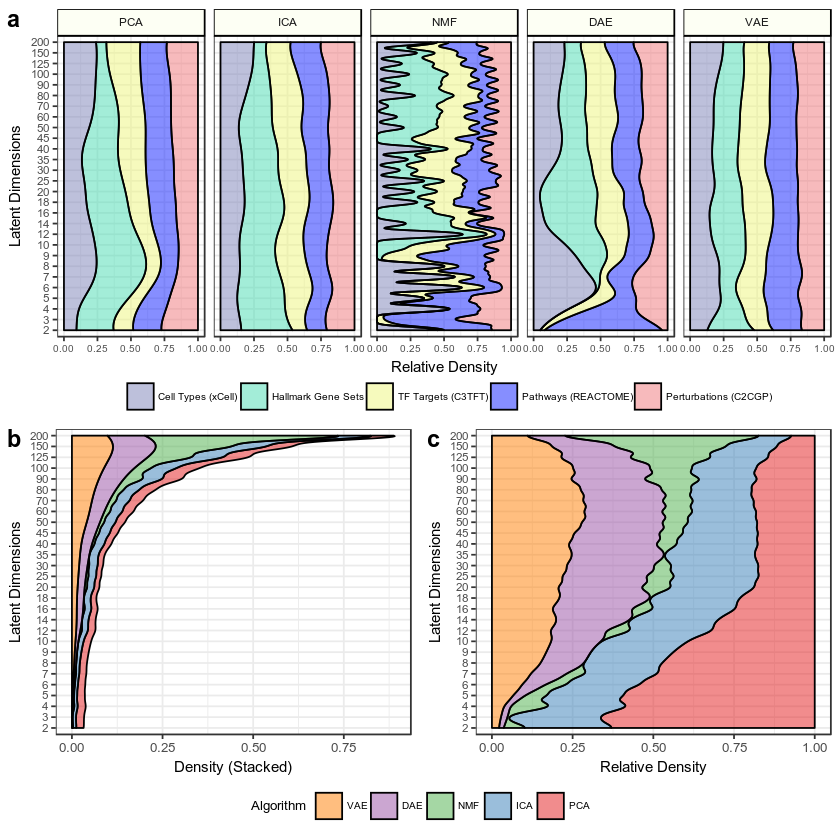

In [12]:
algorithm_legend_gg <- cowplot::get_legend(gtex_fill_gg)

b_and_c_gg <- cowplot::plot_grid(
    gtex_stack_gg + theme(legend.position = "none"),
    gtex_fill_gg + theme(legend.position = "none"),
    ncol = 2,
    labels = c("b", "c")
)

b_and_c_gg <- cowplot::plot_grid(
    b_and_c_gg,
    algorithm_legend_gg,
    rel_heights = c(1, 0.15),
    nrow = 2
)

main_plot <- cowplot::plot_grid(
    tcga_gg,
    b_and_c_gg,
    nrow = 2,
    labels = c("a", "")
)

main_plot

In [13]:
for(extension in c('.png', '.pdf')) {
    gg_file <- paste0("top_feature_density", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = main_plot,
                       base_height = 9,
                       base_width = 8)
}